# Otter populations in california

Project 1

Gail Romer and Mellie Zito

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

from pandas import read_csv

In [2]:
filename = 'Otterdata.csv'
tables = read_csv(filename, header=0, index_col=0, decimal='M');

In [3]:
pup_total = tables.pups
otter_total = tables.total
mature_total = otter_total - pup_total;

In [4]:
pofo = 0.4 #percentage of female otters - may equal this out later (ie 50:50 ratio) no real life support of this number
pomo = 1 - pofo 

female_pups = pup_total * pofo
male_pups = pup_total * pomo

f_mature = (otter_total - pup_total) * pofo
m_mature = (otter_total - pup_total) * pomo;

In [35]:
def plot_results(male_pups, female_pups, f_mature, m_mature, timeseries, timeseries2, title):
    """Plot the estimates and the model.
    
    total: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(female_pups, ':', label='f pups')
    plot(male_pups, ':', label='m pups')
    plot(f_mature, ':', label='f mature')
    plot(m_mature, ':', label='m mature')
#     if len(timeseries):
#         plot(timeseries, color='gray', label='model_mature')
#     if len(timeseries2):
#         plot(timeseries, color='gray', label='model_pups')
    
    plot(timeseries, "--", color='black', label='model_mature')
    plot(timeseries2, color='gray', label='model_pups')
    
    decorate(xlabel='Year', 
             ylabel='Otter Population',
             title=title)

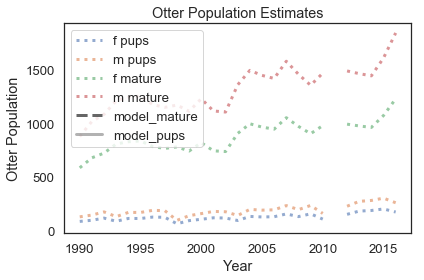

In [36]:
empty = TimeSeries()
empty2 = TimeSeries()
plot_results(male_pups, female_pups, f_mature, m_mature, empty, empty2, 'Otter Population Estimates')

### At what point of less female otters will birth rates be low enough that otter populations die out in the next 20 years in california?

Although otter populations are on the rise now, what effect would a sudden disease have (in this case affecting pups). Relevant
to see how stable otter populations are and to prevent otters from dying out in california

Old question: How would total otter population increase and decrease if otter pup populations were less consistent year to year?

[To remove later:

Parameters: birth and death rates of otters in california

State (from online data table): populations of otter pups and total otters

Metrics: pup and total otter population]

[Description here of question and what's wanted]

### Model

In [37]:
init_f_pups = get_first_value(female_pups)
init_m_pups = get_first_value(male_pups)
init_f_mature = get_first_value(f_mature)
init_m_mature = get_first_value(m_mature)



init_state = State(f_pups=init_f_pups, m_pups=init_m_pups, f_mature=init_f_mature, m_mature=init_m_mature)

,values
f_pups,85.6
m_pups,128.4
f_mature,586.4
m_mature,879.6


Birth rate per female is < 1 per year






             https://seaworld.org/animal-info/animal-infobooks/otters/birth-and-care-of-young                
                
Sea otter gestation range from four to nine months, with an average of six months.
Sea otters give birth throughout the year, with peaks in late May and June for Alaska otters, and March and September for California otters.
Sea otters are capable of giving birth every year, but females usually experience much longer birth intervals.
             https://www.biologicaldiversity.org/species/mammals/sea_otter/natural_history.html
                
                
Female otters reach sexual maturity at three years of age, and males follow at five to six years
Male sea otters live between 10 and 15 years, while females live slightly longer, from 15 to 20 years

In [49]:
system = System(f_birth_rate = .03, #Lets figure out how birth rate relates to F pop
                m_birth_rate = .03, #Lets figure out how birth rate relates to F pop
                maturation_rate = .03,
                f_death_rate = .02, # female vs male death rate subject to change, possibly sweep
                m_death_rate = .02, 
                t_0 = 1990,
                t_end = 2015,
                state = init_state)

,values
f_birth_rate,0.03
m_birth_rate,0.03
maturation_rate,0.03
f_death_rate,0.02
m_death_rate,0.02
t_0,1990
t_end,2015
state,f_pups 85.6 m_pups 128.4 f_mature ...


In [55]:
def update_func1(state, t, system):
    
    
    f_births = system.f_birth_rate * state.f_mature
    
    m_births = system.m_birth_rate * state.m_mature
    
    f_maturlings = system.maturation_rate * state.f_pups
    
    m_maturlings = system.maturation_rate * state.m_pups
        
    f_deaths = system.f_death_rate * state.f_mature
    
    m_deaths = system.m_death_rate * state.m_mature
    
    f_otters = state.f_mature - f_deaths + f_maturlings
    
    m_otters = state.m_mature - m_deaths + m_maturlings
    
    f_pups = state.f_pups + f_births - f_maturlings - system.m_death_rate
    
    m_pups = state.m_pups + m_births - m_maturlings - system.m_death_rate
    
    return State(f_pups=f_pups, m_pups=m_pups, f_mature=f_otters, m_mature=m_otters)

### Results

### Interpretation

### For Later:

In [56]:
state = update_func1(init_state, system.t_0, system)

,values
f_pups,100.604
m_pups,150.916
f_mature,577.240
m_mature,865.860


In [57]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    init: initial State object
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results_mature = TimeSeries()
    results_pups = TimeSeries()
    
    state = system.state
    results_mature[system.t_0] = state.f_mature + state.m_mature
    results_pups[system.t_0] = state.f_pups + state.m_pups
    
    for t in linrange(system.t_0, system.t_end):
        state = update_func(state, t, system)
        results_mature[t+1] = state.f_mature + state.m_mature
        results_pups[t+1] = state.f_pups + state.m_pups
    return results_mature, results_pups

In [58]:
results_mature = run_simulation(system, update_func1)[0];
results_pups = run_simulation(system, update_func1)[1];

print(results_pups)
print(results_mature)

1990    214.000000
1991    251.520000
1992    287.227400
1993    321.224086
1994    353.606306
1995    384.464982
1996    413.886006
1997    441.950519
1998    468.735172
1999    494.312377
2000    518.750542
2001    542.114293
2002    564.464682
2003    585.859385
2004    606.352893
2005    625.996683
2006    644.839389
2007    662.926959
2008    680.302803
2009    697.007932
2010    713.081096
2011    728.558904
2012    743.475946
2013    757.864903
2014    771.756656
2015    785.180380
dtype: float64
1990    1466.000000
1991    1443.100000
1992    1421.783600
1993    1401.964750
1994    1383.562178
1995    1366.499123
1996    1350.703090
1997    1336.105609
1998    1322.642012
1999    1310.251227
2000    1298.875574
2001    1288.460578
2002    1278.954796
2003    1270.309640
2004    1262.479229
2005    1255.420231
2006    1249.091727
2007    1243.455074
2008    1238.473781
2009    1234.113390
2010    1230.341360
2011    1227.126966
2012    1224.441194
2013    1222.256648
2014    122

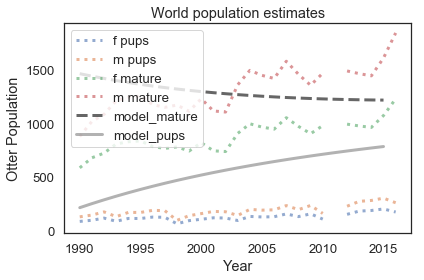

In [59]:
plot_results(male_pups, female_pups, f_mature, m_mature, 
             results_mature, 
             results_pups, 'World population estimates')

### Copied Code



#### How to take in data tables for birth and death rates and trends, then plot that data



In [48]:
filename = 'data/World_population_estimates.html'
#replace with found data table
tables = read_html(filename, header=0, index_col=0, decimal='M')
table2 = tables[2]
table2.columns = ['census', 'prb', 'un', 'maddison', 
                  'hyde', 'tanton', 'biraben', 'mj', 
                  'thomlinson', 'durand', 'clark']

In [ ]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    if len(timeseries):
        plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [ ]:
un = table2.un / 1e9
census = table2.census / 1e9
empty = TimeSeries()
plot_results(census, un, empty, 'World population estimates')

#### Then it goes into making the model:

### System objects

We can rewrite the code from the previous chapter using system objects.

In [ ]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
elapsed_time = t_end - t_0

p_0 = get_first_value(census)
p_end = get_last_value(census)
total_growth = p_end - p_0

annual_growth = total_growth / elapsed_time

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                annual_growth=annual_growth)

And we can encapsulate the code that runs the model in a function.

In [ ]:
def run_simulation1(system):
    """Runs the constant growth model.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = results[t] + system.annual_growth
    
    return results

We can also encapsulate the code that plots the results.

In [ ]:
def plot_results(census, un, timeseries, title):
    """Plot the estimates and the model.
    
    census: TimeSeries of population estimates
    un: TimeSeries of population estimates
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(census, ':', label='US Census')
    plot(un, '--', label='UN DESA')
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='World population (billion)',
             title=title)

In [ ]:
results = run_simulation1(system)
plot_results(census, un, results, 'Constant growth model')

## Proportional model:

In [ ]:
def update_func1(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    #print(t)
    #print(pop)
    births = system.birth_rate * pop
    deaths = system.death_rate * pop
    return pop + births - deaths

In [ ]:
def run_simulation(system, update_func):
    """Simulate the system using any update function.
    
    system: System object
    update_func: function that computes the population next year
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        results[t+1] = update_func(results[t], t, system)
        
    return results

In [ ]:
t_0 = get_first_label(census)
t_end = get_last_label(census)
p_0 = census[t_0]

system = System(t_0=t_0, 
                t_end=t_end,
                p_0=p_0,
                birth_rate=0.027,
                death_rate=0.01)

In [ ]:
results = run_simulation(system, update_func1)
plot_results(census, un, results, 'Proportional model, factored')

### Combines Birth and Death Rates

In [ ]:
def run_simulation2(system):
    """Run a model with proportional birth and death.
    
    system: System object
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(system.t_0, system.t_end):
        births = system.birth_rate * results[t]
        deaths = system.death_rate * results[t]
        results[t+1] = results[t] + births - deaths
        
    return results

system.death_rate = 0.01
system.birth_rate = 0.027

results = run_simulation2(system)
plot_results(census, un, results, 'Proportional model')
savefig('figs/chap03-fig03.pdf')

In [ ]:
def update_func2(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    net_growth = system.alpha  * pop
    return pop + net_growth

In [ ]:
system.alpha = system.birth_rate - system.death_rate

results = run_simulation(system, update_func2)
plot_results(census, un, results, 'Proportional model, combined birth and death')

### Multiple rates:

In [ ]:
def update_func3(pop, t, system):
    """Compute the population next year.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next year
    """
    if t < 1980:
        net_growth = system.alpha1  * pop
    
    if t >= 1980:
        net_growth = system.alpha2 * pop
        
    return pop + net_growth

In [ ]:
system.death_rate1 = 0.01
system.birth_rate1 = 0.027

system.death_rate2 = 0.01
system.birth_rate2 = 0.028

system.alpha1 = system.birth_rate1 - system.death_rate1
system.alpha2 = system.birth_rate2 - system.death_rate2

results = run_simulation(system, update_func3)
plot_results(census, un, results, 'Proportional model, combined birth and death')